## Model Building in XGBoost

This is a great article for tunning XGboost: http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [1]:
import pandas as pd
import numpy as np
import time
import csv
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [2]:
#now we load our modified train and test set

tic()
#train = pd.read_csv('./input-data/train_modified.csv', nrows = 500000)
#test = pd.read_csv('./input-data/test_modified.csv', nrows = 500000)
train = pd.read_csv('./input-data/train_modified.csv',
                    dtype = {'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'rate_change2': 'float64',
                            'rate_change3': 'float64',
                            'rate_change4': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8'},
                   )
                    
val = pd.read_csv('./input-data/val_modified.csv',
                    dtype = {'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'rate_change2': 'float64',
                            'rate_change3': 'float64',
                            'rate_change4': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8'},
                   ) 
    
test = pd.read_csv('./input-data/test_modified.csv',
                    dtype = {'id': 'uint32',
                            'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'rate_change2': 'float64',
                            'rate_change3': 'float64',
                            'rate_change4': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean': 'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8'},
                      )
tac()

Time passed: 0hour:1min:59sec


In [3]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

In [ ]:
import xgboost as xgb
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

def modelfit(alg, dtrain, dval, dtest, predictors, target, IDcol, filename):
    
    #Fit the algorithm on the data
    watchlist = [(dval[predictors], dval[target])]
    alg.fit(dtrain[predictors], dtrain[target], eval_set=watchlist, eval_metric='rmse', early_stopping_rounds=10, verbose=False)
    #alg.fit(dtrain[predictors], dtrain[target],verbose=True)
    
    alg.evals_result()

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Predict validation (holdout) set:
    dval_predictions = alg.predict(dval[predictors])
    dval_predictions = np.maximum(dval_predictions, 0)# we make all negative numbers = 0 since there cannot be a negative demand
    
    #Print model report:
    print ("\nModel Report")
    print ('RMSLE TRAIN: ', np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ('RMSLE VAL: ', np.sqrt(metrics.mean_squared_error(dval[target].values, dval_predictions)))
    
        
    #Predict on testing data: we need to revert it back to target by applying expm1
    dtest[target] = np.expm1(alg.predict(dtest[predictors]))
    
    print ('NUM ROWS PREDICTED: ', dtest.shape[0] )
    print ('NUM NEGATIVES PREDICTED: ', dtest[target][dtest[target] < 0].count())
    print ('MIN TARGET PREDICTED: ', dtest[target].min())
    print ('MEAN TARGET PREDICTED: ', dtest[target].mean())
    print ('MAX TARGET PREDICTED: ', dtest[target].max())
    
    dtest[target] = np.maximum(dtest[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission = dtest[[IDcol,target]].copy()
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)
    

### Alg10 - XGB-1

Looking at the behavior of the sckit-learn models, we should remove pairs_mean feature to get a better prediction. We hence take all other features except Semana and pairs_mean

In [ ]:
predictors = ['Agencia_ID','Canal_ID','Ruta_SAK','Cliente_ID','Producto_ID','Log_Target_mean_lag1',
              'Log_Target_mean_lag2','Log_Target_mean_lag3','Log_Target_mean_lag4',
              'Lags_sum','brand','cluster','Qty_Ruta_SAK_Bin','ZipCode',
              'week_ct','NombreCliente','Producto_ID_clust_ID','Ruta_SAK_clust_ID','Agencia_ID_clust_ID']

alg10 = xgb.XGBRegressor(n_estimators = 300, objective="reg:linear", learning_rate= 0.1, max_depth=10,
                         subsample=0.85,colsample_bytree=0.7)

tic()
modelfit(alg10, train, val, test, predictors, target, IDcol, 'alg10.csv')
tac()

feat_imp = pd.Series(alg10.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

## --> LB: 0.46344

Great improvement from past algos. The most important thing that I see here is that the Feature importance map
is very different from the H2O models. LB Scores between XGB and H2O are similar, so this is a great case for ensembling!

Let's try more estimators

### Alg11 - XGB-2


Model Report
RMSLE TRAIN:  0.458250949434
RMSLE VAL:  0.457084407556
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  236
MIN TARGET PREDICTED:  -0.52534
MEAN TARGET PREDICTED:  5.746615886688232
MAX TARGET PREDICTED:  3610.01
Time passed: 1hour:44min:44sec


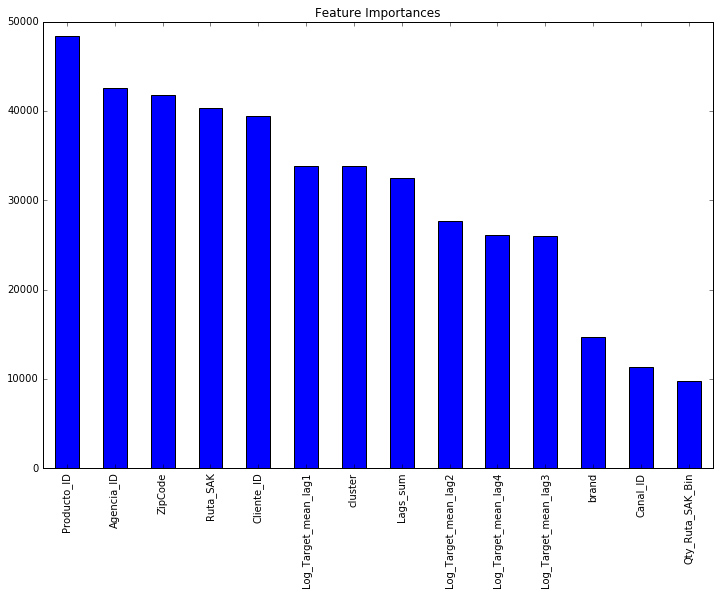

In [30]:
predictors = ['Agencia_ID','Canal_ID','Ruta_SAK','Cliente_ID','Producto_ID','Log_Target_mean_lag1',
                'Log_Target_mean_lag2','Log_Target_mean_lag3','Log_Target_mean_lag4','Lags_sum','brand','cluster',
                'Qty_Ruta_SAK_Bin','ZipCode']

alg11 = xgb.XGBRegressor(n_estimators = 500, objective="reg:linear", learning_rate= 0.1, max_depth=10,
                         subsample=0.5)

tic()
modelfit(alg11, train, val, test, predictors, target, IDcol, 'alg11.csv')
tac()

feat_imp = pd.Series(alg11.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

## --> LB: 0.46299

We improved a little bit as expected.